# Master (Leave-One-Out) Pipeline

This is our master pipeline, which takes us through text pre-processing, LDA topic modeling, leave-one-out cross-validation, and model evaluation.

Our analysis focused on comparing three models:
- a model with baseline measures
- a model with baseline measures and topic distributions
- a model with baseline measures and physician's advice

We want to show that the model with topic distributions performs:
1. better than the baseline model
2. comparably to the model with advice

This pipeline differs from our other Master Pipeline file as this one uses an LDA model that's trained on both conversations (as before), but then applies the model separately to Conversation 1 and Conversation 2. Therefore, with 12 topics, we get 24 features in this file rather than the 12 in the other file. 

## Import Statements

In [1]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import re
import numpy as np
import pandas as pd
from pprint import pprint
from collections import Counter, defaultdict
from IPython.display import clear_output
from matplotlib import pyplot

import warnings
warnings.filterwarnings('ignore')

#gensim for topic modeling with LDA
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import TfidfModel
from gensim.models import NormModel

#spacy for lemmatization
import spacy
import en_core_web_sm

#xgboost for our classification model
from xgboost import XGBClassifier, plot_importance

#sklearn from cross-validation methods
from sklearn.preprocessing import OneHotEncoder, scale, LabelEncoder
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV, LeaveOneOut
from sklearn.ensemble import RandomForestClassifier

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/samanthagarland/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Methods

In [2]:
#for pre-processing our transcripts

nlp = en_core_web_sm.load(disable=['parser', 'ner'])

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stopWords] for doc in texts]

def make_bigrams_combined(texts):
    return [bigram_mod_combined[doc] for doc in texts]

def make_bigrams_convo1(texts):
    return [bigram_mod_convo1[doc] for doc in texts]

def make_bigrams_convo2(texts):
    return [bigram_mod_convo2[doc] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out   

In [3]:
#methods for classification methods
def predict_loo(clf, X_train, y_train, X_test, y_test):
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    clf.fit(X_train, y_train.ravel())
    y_pred_tr = clf.predict(X_train)
    y_pred_ts = clf.predict(X_test)
    return y_pred_tr, y_pred_ts

def compute_metrics(actual, pred):
    accuracy = metrics.accuracy_score(actual, pred)
    precision = metrics.precision_score(actual, pred)
    recall = metrics.recall_score(actual, pred)
    auc = metrics.roc_auc_score(actual, pred)
    return accuracy, precision, recall, auc

## Stop Words
For an explanation of how we created this list, please see our Stop_Word_Rules file.

In [4]:
stopWords = stopwords.words('english')
stopWords = set([word.replace("'", "") for word in stopWords])
stopWords = stopWords.union(set(["dr", "soo", "mmhmmm", "taiwan", "taiwanese", "communist", "mmmhmm", "'", "'cause", "'em", 'a', 'aa', 'aaah', 'aah', 'ab', 'about', 'above', 'african', 'after', 'again', 'against', 'ah', 'ahh', 'ahhh', 'ahhhh', 'ahhm', 'ain', 'aint', 'alabama', 'alaska', 'all', 'alot', 'alright', 'alrighty', 'also', 'am', 'an', 'anand', 'and', 'andand', 'any', 'anyone', 'are', 'aren', 'arent', 'as', 'at', 'ay', 'b', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'bye', 'c', 'california', 'came', 'can', 'cant', 'clean', 'costa_rica', 'could', 'couldn', 'couldnt', 'cuz', 'd', 'de', 'did', 'didn', 'didnt', 'do', 'doc', 'does', 'doesn', 'doesnt', 'doin', 'doing', 'dokey', 'don', 'dont', 'down', 'during', 'e', 'each', 'eek', 'eh', 'em', 'er', 'et', 'etc', 'europe', 'f', 'few', 'florida','for', 'from', 'further', 'g', 'ga', 'gal', 'gee', 'geez', 'germany', 'get', 'go', 'goin', 'going', 'gonna', 'gosh', 'got', 'gotta', 'greek', 'gu', 'h', 'ha', 'had', 'hadn', 'hadnt', 'has', 'hasn', 'hasnt', 'have', 'haven', 'havent', 'having', 'he', 'hed', 'heh', 'hell', 'hello', 'henry', 'her', 'here', 'hers', 'herself', 'hes', 'hey', 'hi', 'him', 'himself', 'his', 'hm', 'hmm', 'hmmm', 'hodgkins', 'how', 'hows', 'huh', 'hum', 'i', 'id', 'if', 'ifif', 'ii', 'iii', 'ill', 'im', 'imrt', 'in', 'inaudible', 'indecipherable', 'indianapolis', 'into', 'is', 'isis', 'isn', 'isnt', 'it', 'itd', 'itit', 'itll', 'its', 'itself', 'ive', 'j', 'jeez', 'just', 'k', 'kay', 'kinda', 'l', 'laughs', 'le', 'leastno', 'legend', 'let', 'lets', 'like', 'll', 'look', 'lot', 'm', 'ma', 'maam', 'md', 'mdmd', 'me', 'mhm', 'mhmm', 'mhmmm', 'michigan', 'mightn', 'mightnt', 'mightve', 'mkay', 'mm', 'mmhm', 'mmhmm', 'mmkay', 'mmm', 'mmmhmm','mmmhmmm', 'mmmm', 'mmmmm', 'more', 'most', 'mustn', 'mustnt', 'mustve', 'my', 'myself', 'n', 'na', 'nah', 'nahuh', 'nd', 'ne', 'needn', 'neednt', 'nn', 'no', 'nooh', 'noooo', 'nope', 'nor', 'not', 'now', 'o', 'of', 'off', 'oh', 'ohh', 'ohhh', 'ohhhohohohoh', 'ohio', 'ok', 'okay', 'okey', 'on', 'once', 'only', 'oooh', 'or', 'oth', 'other', 'othumhmm', 'oughta', 'our', 'ours', 'ourselves', 'out', 'over', 'ow', 'own', 'p', 'patient', 'phi', 'physician', 'potter', 'pt', 'pt/so', 'q', 'r', 'rd', 're', 'right', 'ro', 's', 'said', 'same', 'say', 'see', 'shan', 'shant', 'she', 'shell', 'shes', 'should', 'shouldn', 'shouldnt', 'shouldve', 'so', 'some', 'sorta', 'sounds', 'st', 'stuff', 'such', 'swedish', 't', 'th', 'than', 'that', 'thatd', 'thatll', 'thats', 'thatsthat', 'the', 'their', 'theirs', 'them', 'themselves', 'then', 'there', 'thered', 'thereof', 'theres', 'thereve', 'these', 'thethe', 'thew', 'they', 'theyll', 'theyre', 'theyve', 'thing', 'things', 'this', 'those', 'through', 'ti', 'to', 'too', 'tthe', 'u', 'uh', 'uhh', 'uhhhhh', 'uhhm', 'uhhmm', 'uhhuh', 'uhm', 'uhmhmm', 'uhmhmmm', 'uhmmm', 'uhoh', 'uhum', 'um', 'umhmm', 'umhmmm', 'umm', 'ummm', 'ummmm', 'un', 'under', 'unhunh', 'until', 'up', 'us', 'uuh', 'v', 've', 'very', 'vietnam', 'virginia', 'w', 'walsh', 'wanna', 'was', 'washington', 'wasn', 'wasnt', 'we', 'wed', 'well', 'went', 'were', 'weren', 'werent', 'weve', 'wewe', 'what', 'whatd', 'whatev', 'whatever', 'whatnot', 'whats', 'when', 'where', 'wheres', 'whew', 'which', 'while', 'who', 'whoa', 'whom', 'whos', 'why', 'will', 'with', 'won', 'wont', 'would', 'wouldn', 'wouldnt', 'x', 'y', 'ya', 'yada', 'yah', 'yall', 'yea', 'yeah', 'yep', 'yepvery', 'yer', 'yeyeah', 'you', 'youd', 'youl', 'youll', 'your', 'youre', 'yours', 'yourself', 'yourselves', 'youve', 'youyou', 'yup', 'z']))
print("We have", len(stopWords), "stop words.")

We have 435 stop words.


# Evaluating Our Models

We use accuracy, precision, recall, and AUC as our performance metrics.

## Baseline + Topics

Variables:
- age
- gleason -- cancer grade
- DVD -- control condition from previous study
- tx2_binary -- preference (active surveillance vs treatment) before clinical appointment
- combined_convos -- transcripts from all clinical appointments
- as1 -- physician's advice for active surveillance
- sur1 -- physician's advice for surgery
- rad1 -- physician's advice for radiation therapy

In [6]:
df = pd.read_csv('dvd_advice_text.csv') # 'dvd_withAdvice_final.csv'

factors_all = ["age", "gleason", "DVD", "tx2_binary", "combined_convos", "as1", "sur1", "rad1"]
df = df.dropna(subset=factors_all) #we only want to perform analysis on patients without any missing data for any of our variables
df = df.reset_index(drop=True)
factors_sub = ["age", "gleason", "DVD", "tx2_binary"] #these are the variables we'll actually use for this model

lda_models = [] #keeps track of all lda models we produce

X = df[factors_sub]
y = df["txgot_binary"]
X = np.array(X)
y = np.array(y)
print(len(X))

139


In [7]:
# save indices of missing conversations to convert them into missing data before feeding into XGBoost model
convo1_indices = []
convo2_indices = []
for index, row in df.iterrows():
    if pd.isnull(row['Convo_1']):
        convo1_indices.append(index)
    if pd.isnull(row['Convo_2']):
        convo2_indices.append(index)

In [8]:
print('convo 1 indices', convo1_indices)
print('convo 2 indices', convo2_indices)

convo 1 indices [2, 14, 25, 32, 61, 100, 122, 137]
convo 2 indices [0, 1, 4, 6, 9, 13, 22, 24, 26, 28, 34, 35, 36, 37, 41, 45, 47, 50, 51, 54, 56, 57, 72, 73, 74, 75, 76, 77, 83, 84, 85, 87, 94, 95, 97, 99, 103, 106, 108, 110, 111, 112, 116, 117, 119, 121, 123, 126, 127, 128, 130]


# Processing the Transcripts

Note: As we will be applying the LDA model to conversations 1 and 2 separately, we need to process the texts in three ways: combined, only convo 1, and only convo2. 

In [9]:
#collect all conversations
convo_combined = df["combined_convos"]
convo1 = df["Convo_1"]
convo2 = df["Convo_2"]

data_words_combined = list(sent_to_words(convo_combined))
convo1 = list(sent_to_words(convo1))
convo2 = list(sent_to_words(convo2))

#creates bigrams of words commonly found together
#for example, active_surveillance
bigram_combined = gensim.models.Phrases(data_words_combined, min_count=2, threshold=100) 
bigram_convo1 = gensim.models.Phrases(convo1, min_count=2, threshold=100) 
bigram_convo2 = gensim.models.Phrases(convo2, min_count=2, threshold=100) 

bigram_mod_combined = gensim.models.phrases.Phraser(bigram_combined)
bigram_mod_convo1 = gensim.models.phrases.Phraser(bigram_convo1)
bigram_mod_convo2 = gensim.models.phrases.Phraser(bigram_convo2)

#remove stop words
data_words_nostops_combined = remove_stopwords(data_words_combined)
data_words_nostops_convo1 = remove_stopwords(convo1)
data_words_nostops_convo2 = remove_stopwords(convo2)

data_words_bigrams_combined = make_bigrams_combined(data_words_nostops_combined)
data_words_bigrams_convo1 = make_bigrams_convo1(data_words_nostops_convo1)
data_words_bigrams_convo2 = make_bigrams_convo2(data_words_nostops_convo2)

nlp = spacy.load('en', disable=['parser', 'ner'])

#lemmatize the words
data_lemmatized_combined = lemmatization(data_words_bigrams_combined, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
data_lemmatized_convo1 = lemmatization(data_words_bigrams_convo1, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
data_lemmatized_convo2 = lemmatization(data_words_bigrams_convo2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

#remove stop words again (as lemmatization sometimes reduces words that turn out to be stop words)
data_lemmatized_combined = [[word for word in convo if word not in stopWords] for convo in data_lemmatized_combined]
data_lemmatized_convo1 = [[word for word in convo if word not in stopWords] for convo in data_lemmatized_convo1]
data_lemmatized_convo2 = [[word for word in convo if word not in stopWords] for convo in data_lemmatized_convo2]

### LOOCV Pipeline

In [10]:
#stores the testing predictions and training performance metrics
predictions_ts = []
accuracy_tr = []
precision_tr = []
recall_tr = []
auc_tr = []

# PARAMETERS
# gradient-boosting
max_depth = 3
subsample = 0.9

# LDA
no_below = 0.0 # filters out words that are in fewer than no_below documents
no_above = 0.7 # filters out words that are in more than no_above documents
keep_n = 5000 # dictionary size

loo = LeaveOneOut()
index = 1 # for keeping track of progress

for train_index, test_index in loo.split(X): # Loop over all split possibilities
    # first split up the dataset
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # convert into numpy arrays 
    combined_lemmatized = np.array(data_lemmatized_combined)
    convo1_lemmatized = np.array(data_lemmatized_convo1)
    convo2_lemmatized = np.array(data_lemmatized_convo2)
    
    # construct Dictionary from combined datasets 
    id2word_combined = corpora.Dictionary(combined_lemmatized[train_index]) # build corpus on training data only (NO LEAKAGE)
    id2word_combined.filter_extremes(no_below = no_below, no_above = no_above, keep_n = keep_n, keep_tokens = None)

    # create Bag of words model
    corp_combined = [id2word_combined.doc2bow(text) for text in combined_lemmatized]
    corp_convo1 = [id2word_combined.doc2bow(text) for text in convo1_lemmatized]
    corp_convo2 = [id2word_combined.doc2bow(text) for text in convo2_lemmatized]
    
    corp_combined = np.array(corp_combined)
    corp_convo1 = np.array(corp_convo1)
    corp_convo2 = np.array(corp_convo2)
 
    # split corpus by training and testing indices 
    corp_combined_train = corp_combined[train_index]
    corp_convo1_train = corp_convo1[train_index]
    corp_convo2_train = corp_convo2[train_index]
    
    corp_convo1_test = corp_convo1[test_index]
    corp_convo2_test = corp_convo2[test_index]

    # create LDA Model on combined dataset (on training data only)
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corp_combined_train,
                                           id2word=id2word_combined,
                                           num_topics=12, 
                                           random_state=100,
                                           update_every=3,
                                           chunksize=20,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
    
    # convert back into dataframe so we can append topic distributions
    X_train = pd.DataFrame({'age':X_train[:,0],'gleason':X_train[:,1], "DVD": X_train[:,2], "tx2_binary": X_train[:, 3]})
    X_test = pd.DataFrame({'age':X_test[:,0],'gleason':X_test[:,1],"DVD": X_test[:,2], "tx2_binary": X_test[:, 3]})

    # get topic distributions for convo_1 and convo_2 training
    distributions_convo1 = lda_model[corp_convo1_train] # training
    distributions_convo2 = lda_model[corp_convo2_train]
    length = len(corp_convo1_train) 
    
    topic_dist = [] # topic distributions for convo_1 training
    for i in range(12): # number of topics in topic model
        topic_dist.append([0.0]*length) # initialize all topic distributions to 0
    for en, row in enumerate(distributions_convo1):
        topics = row[0]
        for topic in topics: # list of tuples that contains non-zero topic distributions in format [(1,.034), (4, .458)...]
            topic_dist[topic[0]][en] = topic[1]
        if en in convo1_indices: # if there is no conversation, treat as missing data
            for i in range(12):
                topic_dist[i][en] = np.nan
    for i in range(12): # store topic distributions for convo 1 in training dataframe
        X_train['c1_topic' + str(i)] = topic_dist[i]
        
    topic_dist = [] # topic distributions for convo_2 training
    for i in range(12):
        topic_dist.append([0.0]*length)
    for en, row in enumerate(distributions_convo2):
        topics = row[0]
        for topic in topics:
            topic_dist[topic[0]][en] = topic[1]
        if en in convo2_indices:
            for i in range(12):
                topic_dist[i][en] = np.nan
    for i in range(12):
        X_train['c2_topic' + str(i)] = topic_dist[i]
 
    # get topic distributions for convo_1 and convo_2 testing
    distributions_convo1 = lda_model[corp_convo1_test] # testing
    distributions_convo2 = lda_model[corp_convo2_test]
    length = len(corp_convo1_test) 
    
    topic_dist = [] # topic distributions for convo_1 testing
    for i in range(12):
        topic_dist.append([0.0]*length)
    for en, row in enumerate(distributions_convo1):
        topics = row[0]
        for topic in topics:
            topic_dist[topic[0]][en] = topic[1]
        if en in convo1_indices:
            for i in range(12):
                topic_dist[i][en] = np.nan
    for i in range(12):
        X_test['c1_topic' + str(i)] = topic_dist[i]
        
    topic_dist = [] # topic distributions for convo_2 testing
    for i in range(12):
        topic_dist.append([0.0]*length)
    for en, row in enumerate(distributions_convo2):
        topics = row[0]
        for topic in topics:
            topic_dist[topic[0]][en] = topic[1]
        if en in convo2_indices:
            for i in range(12):
                topic_dist[i][en] = np.nan
    for i in range(12):
        X_test['c2_topic' + str(i)] = topic_dist[i]
   
    # fit model and predict
    xgb = XGBClassifier(max_depth = max_depth, subsample = subsample)
    y_pred_tr, y_pred_ts = predict_loo(xgb, X_train, y_train, X_test, y_test)
    predictions_ts.append(y_pred_ts) #save prediction from each run-through
    
    # compute and store training performance
    acc, prec, rec, auc = compute_metrics(y_train, y_pred_tr)
    accuracy_tr.append(acc)
    precision_tr.append(prec)
    recall_tr.append(rec)
    auc_tr.append(auc)
    
    clear_output(wait=True)
    print('finished round ', index)
    index += 1

finished round  139


In [11]:
# training performance
print('training accuracy: ', np.average(accuracy_tr))
print('training precision: ', np.average(precision_tr))
print('training recall: ', np.average(recall_tr))
print('training auc: ', np.average(auc_tr))

print()

# testing performance
accuracy, precision, recall, auc = compute_metrics(y, predictions_ts)
print('testing accuracy: ', accuracy)
print('testing precision: ', precision)
print('testing recall: ', recall)
print('testing auc ', auc)

training accuracy:  0.9947346470649566
training precision:  0.9984663338847638
training recall:  0.9799689660036677
training auc:  0.9897433572211396

testing accuracy:  0.7697841726618705
testing precision:  0.5263157894736842
testing recall:  0.5882352941176471
testing auc  0.7084033613445379


# Baseline

Variables:
- age
- gleason -- cancer grade
- DVD -- control condition from previous study
- tx2_binary -- preference (active surveillance vs treatment) before clinical appointment

In [12]:
#stores the testing predictions and training performance metrics
predictions_ts = []
accuracy_tr = []
precision_tr = []
recall_tr = []
auc_tr = []

# Define parameters for gradient-boosting algorithm
max_depth = 3
subsample = 0.9

X = df[["age", "gleason", "DVD", "tx2_binary"]]
y = df["txgot_binary"]
X = np.array(X)
y = np.array(y)

loo = LeaveOneOut()

index = 1 # for keeping track of progress

for train_index, test_index in loo.split(X): # Loop over all split possibilities
    #first split up the dataset
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # fit model and predict
    xgb = XGBClassifier(max_depth = max_depth, subsample = subsample)
    y_pred_tr, y_pred_ts = predict_loo(xgb, X_train, y_train, X_test, y_test)
    predictions_ts.append(y_pred_ts)
    
    # compute and store training performance
    acc, prec, rec, auc = compute_metrics(y_train, y_pred_tr)
    accuracy_tr.append(acc)
    precision_tr.append(prec)
    recall_tr.append(rec)
    auc_tr.append(auc)
    
    clear_output(wait=True)
    print('finished round ', index)
    index += 1

finished round  139


In [13]:
# training performance
print('training accuracy: ', np.average(accuracy_tr))
print('training precision: ', np.average(precision_tr))
print('training recall: ', np.average(recall_tr))
print('training auc: ', np.average(auc_tr))

print()

# testing performance
accuracy, precision, recall, auc = compute_metrics(y, predictions_ts)
print('testing accuracy: ', accuracy)
print('testing precision: ', precision)
print('testing recall: ', recall)
print('testing auc ', auc)

training accuracy:  0.8702950682931916
training precision:  0.8404059000117805
training recall:  0.5803229074494415
training auc:  0.7722509469652932

testing accuracy:  0.7553956834532374
testing precision:  0.5
testing recall:  0.38235294117647056
testing auc  0.6292717086834734


# Baseline and Advice

Variables:
- age
- gleason -- cancer grade
- DVD -- control condition from previous study
- tx2_binary -- preference (active surveillance vs treatment) before clinical appointment
- as1 -- physician's advice for active surveillance
- sur1 -- physician's advice for surgery
- rad1 -- physician's advice for radiation therapy

In [14]:
#stores the testing predictions and training performance metrics
predictions_ts = []
accuracy_tr = []
precision_tr = []
recall_tr = []
auc_tr = []

# Define parameters for xgboost
max_depth = 3
subsample = 0.9

X = df[["age", "gleason", "DVD", "tx2_binary", "as1", "sur1", "rad1"]]
y = df["txgot_binary"]
X = np.array(X)
y = np.array(y)

loo = LeaveOneOut()

index = 1 # for keeping track of progress

for train_index, test_index in loo.split(X): # Loop over all split possibilities
    #first split up the dataset
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # fit model and predict
    xgb = XGBClassifier(max_depth = max_depth, subsample = subsample)
    y_pred_tr, y_pred_ts = predict_loo(xgb, X_train, y_train, X_test, y_test)
    predictions_ts.append(y_pred_ts)
    
    # compute and store training performance
    acc, prec, rec, auc = compute_metrics(y_train, y_pred_tr)
    accuracy_tr.append(acc)
    precision_tr.append(prec)
    recall_tr.append(rec)
    auc_tr.append(auc)
    
    clear_output(wait=True)
    print('finished round ', index)
    index += 1

finished round  139


In [15]:
# training performance
print('training accuracy: ', np.average(accuracy_tr))
print('training precision: ', np.average(precision_tr))
print('training recall: ', np.average(recall_tr))
print('training auc: ', np.average(auc_tr))

print()

# testing performance
accuracy, precision, recall, auc = compute_metrics(y, predictions_ts)
print('testing accuracy: ', accuracy)
print('testing precision: ', precision)
print('testing recall: ', recall)
print('testing auc ', auc)

training accuracy:  0.9393181107288082
training precision:  0.8825104214664199
training recall:  0.8680413957603971
training auc:  0.9152109105452314

testing accuracy:  0.7769784172661871
testing precision:  0.5517241379310345
testing recall:  0.47058823529411764
testing auc  0.673389355742297


# Compute Feature Importances

After using the metrics from above to determine that the parameters we set lead to good accuracy and AUC, we run this on the entire corpus of transcripts to create our master model. From this model, we calculate the feature importances of the variables.

In [16]:
df = pd.read_csv('dvd_withAdvice_final.csv')

factors_all = ["age", "gleason", "DVD", "tx2_binary", "combined_convos", "as1", "sur1", "rad1"]
df = df.dropna(subset=factors_all) # we only want to perform analysis on patients without any missing data for any of our variables
df = df.reset_index(drop=True)

factors_sub = ["age", "gleason", "DVD", "tx2_binary"] #these are the variables we'll actually use for this model
X = df[factors_sub]
y = df["txgot_binary"]

# save indices of missing conversations to convert them into missing data before feeding into XGBoost model
convo1_indices = []
convo2_indices = []
for index, row in df.iterrows():
    if pd.isnull(row['Convo_1']):
        convo1_indices.append(index)
    if pd.isnull(row['Convo_2']):
        convo2_indices.append(index)

X = np.array(X)
y = np.array(y)

#collect all conversations
convo_combined = df["combined_convos"]
convo1 = df["Convo_1"]
convo2 = df["Convo_2"]

data_words_combined = list(sent_to_words(convo_combined))
convo1 = list(sent_to_words(convo1))
convo2 = list(sent_to_words(convo2))

#creates bigrams of words commonly found together
#for example, active_surveillance
bigram_combined = gensim.models.Phrases(data_words_combined, min_count=2, threshold=100) 
bigram_convo1 = gensim.models.Phrases(convo1, min_count=2, threshold=100) 
bigram_convo2 = gensim.models.Phrases(convo2, min_count=2, threshold=100) 

bigram_mod_combined = gensim.models.phrases.Phraser(bigram_combined)
bigram_mod_convo1 = gensim.models.phrases.Phraser(bigram_convo1)
bigram_mod_convo2 = gensim.models.phrases.Phraser(bigram_convo2)

#remove stop words
data_words_nostops_combined = remove_stopwords(data_words_combined)
data_words_nostops_convo1 = remove_stopwords(convo1)
data_words_nostops_convo2 = remove_stopwords(convo2)

data_words_bigrams_combined = make_bigrams_combined(data_words_nostops_combined)
data_words_bigrams_convo1 = make_bigrams_convo1(data_words_nostops_convo1)
data_words_bigrams_convo2 = make_bigrams_convo2(data_words_nostops_convo2)

nlp = spacy.load('en', disable=['parser', 'ner'])

#lemmatize the words
data_lemmatized_combined = lemmatization(data_words_bigrams_combined, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
data_lemmatized_convo1 = lemmatization(data_words_bigrams_convo1, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
data_lemmatized_convo2 = lemmatization(data_words_bigrams_convo2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

#remove stop words again (as lemmatization sometimes reduces words that turn out to be stop words)
data_lemmatized_combined = [[word for word in convo if word not in stopWords] for convo in data_lemmatized_combined]
data_lemmatized_convo1 = [[word for word in convo if word not in stopWords] for convo in data_lemmatized_convo1]
data_lemmatized_convo2 = [[word for word in convo if word not in stopWords] for convo in data_lemmatized_convo2]

In [17]:
#PARAMETERS:

#xgboost
max_depth = 3
subsample = 0.9

#LDA
no_below = 0.1
no_above = 0.7
keep_n = 5000

# construct Dictionary from combined datasets 
id2word_combined = corpora.Dictionary(combined_lemmatized) # build corpus on training data only (NO LEAKAGE)
id2word_combined.filter_extremes(no_below = no_below, no_above = no_above, keep_n = keep_n, keep_tokens = None)

# create Bag of words model
corp_combined = [id2word_combined.doc2bow(text) for text in combined_lemmatized]
corp_combined = np.array(corp_combined)
corp_convo1 = [id2word_combined.doc2bow(text) for text in convo1_lemmatized]
corp_convo1 = np.array(corp_convo1)
corp_convo2 = [id2word_combined.doc2bow(text) for text in convo2_lemmatized]
corp_convo2 = np.array(corp_convo2)

# Create LDA Model with combined corpus from above
lda_model = gensim.models.ldamodel.LdaModel(corpus=corp_combined,
                                       id2word=id2word_combined,
                                       num_topics=12, 
                                       random_state=100,
                                       update_every=3,
                                       chunksize=20,
                                       passes=10,
                                       alpha='auto',
                                       per_word_topics=True)

# revert X back to dataframe so we can add on the topic distributions
X = pd.DataFrame({'age':X[:,0],'gleason':X[:,1], "DVD": X[:,2], "tx2_binary": X[:, 3]})

# get topic distributions for convo_1 and convo_2 
distributions_convo1 = lda_model[corp_convo1] # 
distributions_convo2 = lda_model[corp_convo2]
length = len(corp_convo1) 
    
topic_dist = [] # topic distributions for convo_1 training
for i in range(12): # number of topics in topic model
    topic_dist.append([0.0]*length)
for en, row in enumerate(distributions_convo1):
    topics = row[0]
    for topic in topics: # list of tuples that contains non-zero topic distributions in format [(1,.034), (4, .458)...]
        topic_dist[topic[0]][en] = topic[1]
    if en in convo1_indices:
        for i in range(12):
            topic_dist[i][en] = np.nan
for i in range(12):
    X['c1_topic' + str(i)] = topic_dist[i]

topic_dist = [] # topic distributions for convo_2 training
for i in range(12):
    topic_dist.append([0.0]*length)
for en, row in enumerate(distributions_convo2):
    topics = row[0]
    for topic in topics:
        topic_dist[topic[0]][en] = topic[1]
    if en in convo2_indices:
        for i in range(12):
            topic_dist[i][en] = np.nan
for i in range(12):
    X['c2_topic' + str(i)] = topic_dist[i]

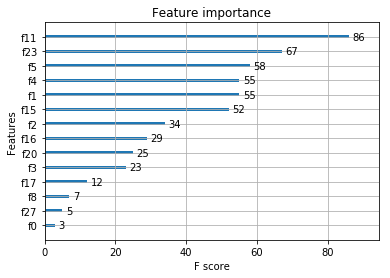

['c1_topic7', 0.16829745]
['c2_topic7', 0.13111547]
['c1_topic1', 0.113502935]
['age', 0.10763209]
['c1_topic0', 0.10763209]
['c1_topic11', 0.10176125]
['gleason', 0.0665362]
['c2_topic0', 0.056751467]
['c2_topic4', 0.04892368]
['tx2_binary', 0.045009784]
['c2_topic1', 0.023483366]
['c1_topic4', 0.01369863]
['c2_topic11', 0.009784736]
['DVD', 0.0058708414]
['c2_topic10', 0.0]
['c1_topic8', 0.0]
['c1_topic10', 0.0]
['c1_topic6', 0.0]
['c1_topic5', 0.0]
['c2_topic2', 0.0]
['c1_topic3', 0.0]
['c1_topic2', 0.0]
['c2_topic3', 0.0]
['c2_topic5', 0.0]
['c2_topic6', 0.0]
['c2_topic8', 0.0]
['c2_topic9', 0.0]
['c1_topic9', 0.0]


In [18]:
#create our model
clf = XGBClassifier(max_depth = max_depth, subsample = subsample)
X_np = np.array(X)
clf.fit(X_np, y)

#plots the feature importances
temp = plot_importance(clf)
pyplot.show(temp)

#lists the features in order of importance
sorted_idx = np.argsort(clf.feature_importances_)[::-1]
for index in sorted_idx:
    print([X.columns[index], clf.feature_importances_[index]]) 

+ ['c1_topic11', 0.19094488], ['age', 0.16929133], ['c2_topic7', 0.15551181], ['c1_topic7', 0.12992126], ['c1_topic0', 0.10236221], ['gleason', 0.07874016], ['c2_topic11', 0.061023623], ['tx2_binary', 0.05511811], ['c2_topic0', 0.037401576], ['DVD', 0.00984252], ['c1_topic1', 0.007874016], ['c2_topic1', 0.001968504]

# Viewing the Topics

In [19]:
#print the top words used to form each topic
print("DVD Topics:")
pprint(lda_model.print_topics(num_words=50))

DVD Topics:
[(0,
  '0.009*"robotic" + 0.008*"erectile" + 0.005*"book" + 0.005*"situation" + '
  '0.005*"robot" + 0.004*"lymph_node" + 0.004*"sphincter" + 0.004*"pad" + '
  '0.004*"physical" + 0.003*"generally" + 0.003*"volume" + 0.003*"additional" '
  '+ 0.003*"outside" + 0.003*"rare" + 0.003*"spare" + 0.003*"damage" + '
  '0.003*"tumor" + 0.003*"activity" + 0.003*"bowel" + 0.003*"rate" + '
  '0.003*"heal" + 0.003*"pathologist" + 0.003*"pathology" + 0.003*"research" + '
  '0.003*"anywhere" + 0.003*"fix" + 0.003*"dry" + 0.003*"level" + 0.003*"add" '
  '+ 0.003*"wear" + 0.003*"recover" + 0.003*"middle" + 0.003*"penis" + '
  '0.003*"kill" + 0.003*"health" + 0.002*"viagra" + 0.002*"stage" + '
  '0.002*"write" + 0.002*"learn" + 0.002*"scar" + 0.002*"notice" + 0.002*"top" '
  '+ 0.002*"soon" + 0.002*"freeze" + 0.002*"definitely" + 0.002*"nurse" + '
  '0.002*"ability" + 0.002*"active" + 0.002*"bathroom" + 0.002*"blood_flow"'),
 (1,
  '0.005*"dad" + 0.004*"listen" + 0.004*"hormone" + 0.004*"br

# Topic Distributions by Class

In [20]:
y_pred = clf.predict(X_np)
X['pred'] = y_pred
X_0 = X[X.pred == 0]
X_1 = X[X.pred == 1]
X_0 = X_0[['c1_topic0', 'c1_topic1', 'c1_topic2', 'c1_topic3', 'c1_topic4', 'c1_topic5', 'c1_topic6', 'c1_topic7', 'c1_topic8', 'c1_topic9', 'c1_topic10', 'c1_topic11', 'c2_topic0', 'c2_topic1', 'c2_topic2', 'c2_topic3', 'c2_topic4', 'c2_topic5', 'c2_topic6', 'c2_topic7', 'c2_topic8', 'c2_topic9', 'c2_topic10', 'c2_topic11']]
X_1 = X_1[['c1_topic0', 'c1_topic1', 'c1_topic2', 'c1_topic3', 'c1_topic4', 'c1_topic5', 'c1_topic6', 'c1_topic7', 'c1_topic8', 'c1_topic9', 'c1_topic10', 'c1_topic11', 'c2_topic0', 'c2_topic1', 'c2_topic2', 'c2_topic3', 'c2_topic4', 'c2_topic5', 'c2_topic6', 'c2_topic7', 'c2_topic8', 'c2_topic9', 'c2_topic10', 'c2_topic11']]

In [21]:
np.set_printoptions(formatter={'float_kind':'{:f}'.format})

In [22]:
vals_1 = X_1.mean().values # use to choose non-negligible topics for visualization
vals_1

array([0.158864, 0.233513, 0.000000, 0.000000, 0.018667, 0.000000,
       0.000000, 0.398491, 0.000000, 0.011411, 0.000000, 0.177052,
       0.090767, 0.151919, 0.000000, 0.000000, 0.026933, 0.000000,
       0.000000, 0.646902, 0.000000, 0.000000, 0.000000, 0.082709])

In [23]:
vals_0 = X_0.mean().values
vals_0 = [vals_0[0], vals_0[1], vals_0[7], vals_0[11], vals_0[12], vals_0[19], vals_0[23]]
vals_1 = X_1.mean().values
vals_1 = [vals_1[0], vals_1[1], vals_1[7], vals_1[11], vals_1[12], vals_1[19], vals_1[23]]
print(vals_0)
print(vals_1)

[0.19307265152205147, 0.3128256638917853, 0.35945929339447735, 0.09635433732696316, 0.09895522745353157, 0.6061195404255304, 0.05772495250878991]
[0.15886403446824388, 0.23351348612200598, 0.3984910099413888, 0.1770519653078297, 0.09076719108576838, 0.6469017698576576, 0.08270879423147753]


[0, 1, 2, 3, 4, 5, 6]
[0.25, 1.25, 2.25, 3.25, 4.25, 5.25, 6.25]
[0.1, 1.1, 2.1, 3.1, 4.1, 5.1, 6.1]


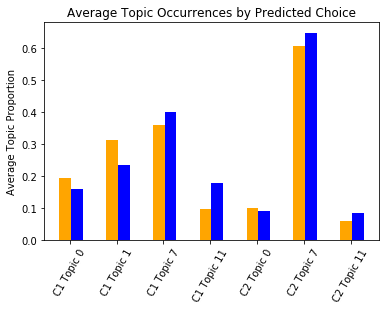

In [25]:
import matplotlib.pyplot as plt
x = ['C1 Topic 0', 'C1 Topic 1', 'C1 Topic 7', 'C1 Topic 11', 'C2 Topic 0', 'C2 Topic 7', 'C2 Topic 11']
x_pos0 = [i for i, _ in enumerate(x)]
x_pos1 = [i+0.25 for i in x_pos0]
x_pos_middle = [i+0.1 for i in x_pos0]
print(x_pos0)
print(x_pos1)
print(x_pos_middle)

plt.bar(x_pos0, vals_0, color='orange',width=0.25)
plt.bar(x_pos1, vals_1, color='blue', width=0.25)
plt.ylabel("Average Topic Proportion")
plt.title("Average Topic Occurrences by Predicted Choice")
plt.xticks(x_pos_middle, x, rotation=60)
plt.show()